In [18]:
# coding=utf-8

import os
from copy import copy
from datetime import datetime, timedelta

import talib
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from tumbler.service.mysql_service import MysqlService
from tumbler.object import BarData
from tumbler.function import get_sum_dic, get_sum_from_dic, get_mul_sum_dic
import tumbler.function.figure as figure
from tumbler.constant import Interval
from tumbler.function.technique import PD_Technique, Technique
from tumbler.constant import Direction
from tumbler.record.client_quick_query import get_future_symbols
from tumbler.constant import EvalType

sys_path_dir = ".tumbler"
mysql_service_manager = MysqlService()
day_binance_file = os.path.join(sys_path_dir, "binance_day.csv")

def day_func(df):
    # val_arr = talib.ADX(df["high"], df["low"], df["close"], timeperiod=14) * \
    #           talib.ADXR(df["high"], df["low"], df["close"], timeperiod=14)
    val_arr = talib.ROC(df["close"], timeperiod=30)
    # val_arr = Technique.boll(df["close"], 20, dev=1)
    # val_arr = np.array(Technique.der(df["close"], n=20))

    return val_arr


def get_use_symbols(suffix, all_data=True):
    day_symbols = mysql_service_manager.get_mysql_distinct_symbol(table='kline_1day')
    day_symbols = [x for x in day_symbols if
                   x.endswith(suffix) and not x.endswith("down_usdt")
                   and not x.endswith("up_usdt") and not x.endswith("bear_usdt") 
                   and not x in ["drep_usdt", "cocos_usdt"]]
    if not all_data:
        day_symbols = [x for x in day_symbols if x in get_future_symbols(reload=False)]
    else:
        day_symbols = day_symbols
    return day_symbols

def get_df():
    df = pd.read_csv(day_binance_file)
    return df

def run(suffix="_usdt", all_data=True, start_time=datetime(2017, 1, 1), end_time=datetime.now() + timedelta(hours=3)):
    # make_local_binance_day_csv()
    day_symbols = get_use_symbols(suffix, all_data)
    val_dic = {}

    df = get_df()

    for symbol in day_symbols:
        if symbol.endswith(suffix):
            tdf = copy(df[df.symbol == symbol])
            if len(tdf.index) == 0:
                continue

            val_arr = day_func(tdf)

            n = len(tdf["date"])
            l_date = list(tdf["date"])
            val_arr = list(val_arr)

            for i in range(n):
                s_datetime = l_date[i]
                if s_datetime not in val_dic.keys():
                    val_dic[s_datetime] = []

                val_dic[s_datetime].append((val_arr[i], symbol))
    
    dt_arr = list(val_dic.keys())
    dt_arr.sort()
    
    symbols_dict = {}
    scores_dict = {}
    avg_rise_dict = {}
    
    for dt in dt_arr:
        if str(start_time) <= dt <= str(end_time):
            symbols_dict[dt] = []
            scores_dict[dt] = []
            val_dic[dt].sort(reverse=True)
            
            for v, symbol in val_dic[dt][:10]:
                if str(v) != str(np.nan):
                    symbols_dict[dt].append(symbol)
                    scores_dict[dt].append(v)
                    
                if v > 2000:
                    print(symbol, v, dt)
            
            if len(scores_dict[dt]) > 0:
                avg_rise_dict[dt] = sum(scores_dict[dt]) * 1.0 / len(scores_dict[dt])
            else:
                avg_rise_dict[dt] = 0
    
    data_dic = {"avg_rise_dict": avg_rise_dict}
    new_df = pd.DataFrame(data_dic)
    new_df.to_csv("avg_rise.csv")
    return new_df
    

new_df = run(suffix="_usdt", all_data=True)
                


chz_usdt 2380.1813162468898 2021-03-12 00:00:00


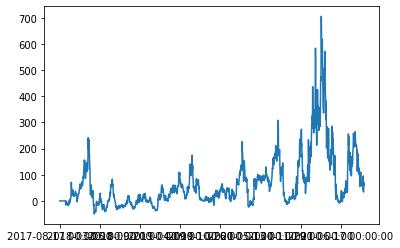

In [22]:
new_df["minus_avg_rise_dict"] = new_df["avg_rise_dict"] - new_df["avg_rise_dict"].shift(1)
new_df["avg_rise_dict"].plot()


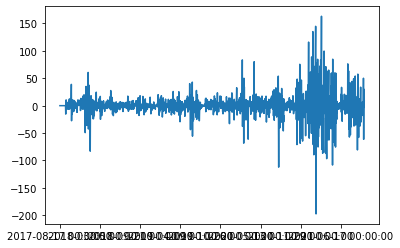

In [21]:
new_df["minus_avg_rise_dict"].plot()